## Session3-2: Xarray and DHS Heat Data Extraction
<hr style="border-top: 1px solid gray; margin-top: 24px; margin-bottom: 1px"></hr>

In our previous tutorial, we explored the fundamentals of handling geospatial raster data, focusing on computing zonal statistics for Ghana's administrative regions using `rasterio` and `geopandas`. We looked into how we can extract meaningful statistics from raster data based on various administrative zones. This allowed us to perform targeted analyses on regional and district levels, providing insights into spatial variations in climate-related indices such as heat.

While our previous approach was effective for specific tasks, the nature of climate data often requires handling more complex, multidimensional datasets. These datasets typically include variables distributed across different dimensions—*time, latitude, and longitude*—making them ideal candidates for analysis with `Xarray`, a powerful Python library designed specifically for handling such data structures.

#### Why Xarry?
[**Xarray**](https://docs.xarray.dev/en/stable/user-guide/dask.html) introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays, which makes data more intuitive to reason about. With Xarray, we can perform more sophisticated analyses that involve:
- <ins>Time-series Analysis</ins>: Climate data often comes as time series, with measurements spanning multiple timestamps. Xarray makes it easy to manipulate such data, allowing for temporal querying and resampling operations which are essential for trend analysis and forecasting.
- <ins>Multi-dimensional Operations</ins>: Xarray supports broadcasting and vectorized operations on multi-dimensional data, making complex climate modeling and data aggregation straightforward.

#### Understanding Xarray's Data Structures

Xarray introduces two main data structures: `DataArray` and `Dataset`. These structures are built on top of NumPy and pandas. We recommend you read about [`Xarray` data structures](https://docs.xarray.dev/en/stable/user-guide/data-structures.html) because the terminology can be a bit confusing

A `DataArray` is Xarray’s implementation of a labeled, multi-dimensional array.

- Values: a numpy.ndarray or numpy-like array holding the array’s values
- Dimensions: These are names for each axis of the array. For instance, in climate data, common dimensions include 'time', 'latitude', and 'longitude'.
- Coordinates: These are arrays that label each point, such as specific dates for the 'time' dimension or longitude and latitude values for geographical dimensions. Coordinates enable powerful and intuitive data selections.
- Attributes: These are metadata for the array, used to store arbitrary metadata such as the description of the dataset, units of measurement, or other relevant information.

A `Dataset` is a dictionary-like container that holds multiple variables (arrays) that potentially share the same coordinates. It is analogous to a pandas DataFrame but can handle multi-dimensional data. Each variable in a Dataset is itself a DataArray.

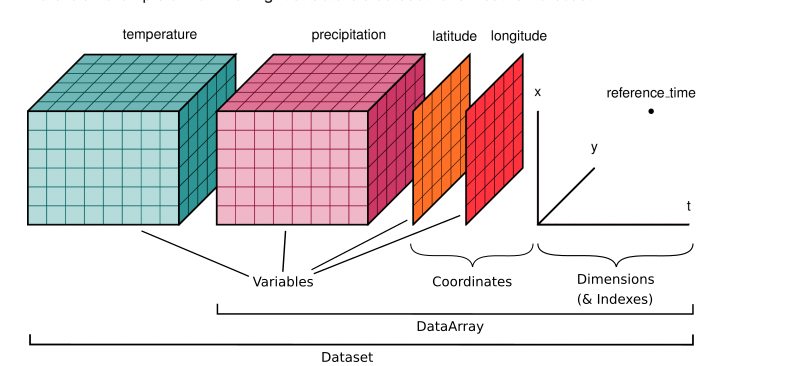

Basically, `Xarray` allows you to create labeled n-dimentional numpy arrays. So you can label your datasets (temperature, precipitation, etc.) and your dimentions (time, lat/long, etc.) to easily subset the data to run analysis. For example, you could say, what is the average heat index in Accra based on Lat/Long with just a few lines of code. **Note** We will use the package [`rioxarray`](https://corteva.github.io/rioxarray/html/rioxarray.html) too to load in the GeoTiff files. More on this later. Let's get started!

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [ ]:
# =============================================================================
# SETUP CELL - Run this first before importing packages
# =============================================================================

"""
This cell installs geospatial packages not included in Google Colab by default.
These are essential for working with climate and satellite data.

Packages being installed:
- rioxarray: an extension of the powerful Python library Xarray that focuses on geospatial raster data

"""
!pip install rioxarray

In [ ]:
# Dependencies
import os
import glob
import xarray as xr
import dask
import rioxarray as rio
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

### A Toy Dataset
Let's start by making two toy data xarray data arrays and turn them into an xarray dataset with temperature and precipitation. They will be 100 by 100 by 30 arrays, representing 100 by 100 lat/long and 30 days.

In [ ]:
# make an empty temperature array
# temperature range from low:20 to high:100 (exclusive), integer
temp = np.random.randint(20, high=100, size=(100,100,30), dtype=int)
temp.shape

In [ ]:
# you can print the generated temperature array if want
temp

In [ ]:
# make an empty precip array
# percipitation ragnge from low:0 to high:10 (exclusive), integer
precip = np.random.randint(0, high= 10, size=(100,100,30), dtype=int)
precip.shape

In [ ]:
# make a 30 day time stamp
time = pd.date_range("2016-01-01", periods=30)
time

In [ ]:
len(time)

In [ ]:
# make x and y index values from 1 to 100
x = list(range(1,100+1))
y = list(range(1,100+1))

In [ ]:
# Turn temp into xarray data array
temp_da = xr.DataArray(data = temp, # data
                       dims = ['x', 'y', 'time'], # dim labels as a list
                       coords = {'x' : x, 'y' : y, 'time' : time}, # coords data as a dict
                       name = 'temp' # name the da
                      )
temp_da

In [ ]:
# Turn precip into xarray data array
precip_da = xr.DataArray(data = precip, # data
                       dims = ['x', 'y', 'time'], # dim labels as a list
                       coords = {'x' : x, 'y' : y, 'time' : time}, # coords data as a dict
                       name = 'precip' # name the da
                      )
precip_da

In [ ]:
# Now combine temp and precip into a xarry dataset
ds = xr.merge([temp_da, precip_da])
ds

Did you see the difference between data array and dataset?

#### A bit about Xarray Datasets

Xarray Datasets are nice because you can easily stack several data arrays and run analysis on the data. Like numpy arrays, they must be the same size. But unlike numpy arrays, you have labels, so it is easy to subset the data.

In [ ]:
# access the temp data
ds.temp

In [ ]:
# access the precip data
ds.precip

In [ ]:
# Estimate correlation between precip and temperature over time
corr = xr.corr(ds.temp, ds.precip, dim= 'time')
corr

## Let's look at some real data using Xarry
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

Let's now use `rioxarry` to open our maximum heat index data for the whole 2016!<br>

[`rio.open_rasterio()`](https://corteva.github.io/rioxarray/html/rioxarray.html) is a function provided by the 'rioxarray' library, an extension of 'xarra'y specifically designed to facilitate the handling of raster data within the geospatial data analysis context.

- Raster Reading: Opens raster files (like GeoTIFFs), loading them into xarray.DataArray while preserving geospatial metadata including CRS and spatial dimensions.
- Masking Support: Automatically masks nodata values by converting them to NaN in the DataArray, ensuring clean and accurate data analysis.
- CRS Handling: Reads and attaches the CRS from the raster file to the DataArray for precise spatial operations.
- Chunking for Large Data: Supports integration with `Dask` to read data in chunks, facilitating the handling of large datasets that exceed memory capacity.


<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Get the path to your files in a list files
base_dir = 'drive/MyDrive/Climate-Health-Data-Science-Workshop/Day3/'
path = os.path.join(base_dir, 'data/himax-2016/')
fns = sorted(glob.glob(path + '*.tif'))

# print first five files to make sure they are in order
fns[:5]

### Load a 'view' of all 366 files into a Xarray DataSet

The code below will read all the files into memory, and create a Multi-Dimensional DataArray for the max heat index of 2016. Note that for this tutorial, we are directly loading all raster files (since our file is small), but in real-world practice this is not usually recommended, as it will squeeze up the memory quickly, especially when working with large climate datasets. At the end of this tutorial, we will provide some information about `Dask`, a flexible parallel computing library, but later!


In [ ]:
# initilize an empty list to store the raster DataArray
himax_arrays = []

for fn in fns:
    # Use rioxarray (aliased as rio) to open and handle the raster file
    da = rio.open_rasterio(fn, masked=True) # this will mask out the NaN values
    da = da.sel(band=1)  # Select the first band if more than one band exists
    da.name = 'himax'  # Set the name for each DataArray
    himax_arrays.append(da)

In [ ]:
# Combine all DataArrays into a single Dataset along the 'band' dimension
himax_arrays = xr.concat(himax_arrays, dim='band')

In [ ]:
# you can check the DataArrays
himax_arrays

What did you observe? did you see a time variable on the coordinates?

In [ ]:
# Make a pandas time daily time series for 2016
time = pd.date_range("2016-01-01", periods=366)
time

In [ ]:
# rename time dim
himax_arrays = himax_arrays.rename({'band' : 'time'})

# Revalue the time' coord
himax_arrays['time'] = time
himax_arrays

In [ ]:
# for better readibility, you can also rename the x,y to long and lat
himax_arrays = himax_arrays.rename({'x': 'long', 'y': 'lat'})

himax_arrays

##### Export Xarray to NetCDF
Exporting Xarray data to NetCDF format is a common practice in the fields of climate science, oceanography, meteorology, and other environmental sciences. NetCDF (Network Common Data Form) is a set of software libraries and machine-independent data formats that support the creation, access, and sharing of array-oriented scientific data

In [ ]:
# Export the combined dataset to a NetCDF file
#output_path = os.path.join(base_dir, 'data/himax_ghana_2016.nc')
#himax_arrays.to_netcdf(output_path)

### Read a NetCDF File with Xarray

Reading a NetCDF file using xarray is straightforward due to its built-in support for this format, which is commonly used in scientific and climate-related data analysis

<div class="run">
    ▶️ <b> Run the cells below. </b>
</div>

In [ ]:
# Path to the NetCDF file
fn = os.path.join(base_dir, 'data/himax_ghana_2016.nc')

# Open the NetCDF file as a xarry.Dataset
ds = xr.open_dataset(fn)

# set the spatial_ref as coordinate
ds = ds.set_coords('spatial_ref')

In [ ]:
ds

Xarray typically employs <ins>lazy loading with NetCDF files</ins>. This means it does not load the data into memory until you explicitly request it to do so. This approach is beneficial for working with large datasets because it allows you to operate on metadata and prepare operations without the overhead of loading potentially huge arrays into memory.

In [ ]:
ds.load()  # This will load the data into memory
ds

In [ ]:
# read the maximum heat index da
himax = ds.himax
himax

### Subsetting data

There are tons of ways to slice Xarray Data Arrays. In Xarray, the methods `.sel()`(*selection by Label*) and `.isel()`(*selection by Integer Index*) are used to select data from an `xarray.Dataset` or `xarray.DataArray`. Subsetting allows you to focus on specific periods or regions where heat extremes could be a concern. Here are two examples:

In [ ]:
# Subsetting by a specific time range during a hot period
summer_himax = ds['himax'].sel(time=slice('2016-06-01', '2016-08-31'))
summer_himax

In [ ]:
# Subsetting by latitude and longitude to focus on a specific area
regional_himax = ds['himax'].sel(lat=slice(10, 7), long=slice(-1, 1)) #latitude is in descending order
regional_himax

In [ ]:
# Select by set by col / row
subset = himax.isel(lat=slice(60, 90), long=slice(40, 70)) #select rows from 61st to 90th, columns from 41st to 70th
subset

### Calculating Mean Heat Values
Heat index values are crucial for understanding heat stress on humans. Here's how you can analyze the 'himax' data over different time scales:

In [ ]:
# Calculate the annual mean to get an idea of the average maximum heat index over the entire year
annual_mean_himax = ds['himax'].mean(dim='time')
annual_mean_himax

In [ ]:
# Monthly means can show you how heat conditions change over the year, which is useful for seasonal analysis
monthly_mean_himax = ds['himax'].groupby('time.month').mean()
monthly_mean_himax

In [ ]:
# Calculate Seasonal Mean
seasonal_mean_himax = ds['himax'].groupby('time.season').mean()
seasonal_mean_himax

### Ploting data

In [ ]:
# plot the annual mean heat index
arr = annual_mean_himax.data
plt.imshow(arr)
plt.colorbar(shrink = 0.7)
plt.title('Average Daily Maximum Heat Index for Ghana 2016');

### Save your the daily average heat index for 2016 as a tif file

In [ ]:
# get the meta data
meta = rasterio.open(fns[0]).meta

In [ ]:
# make a file name
fn_out = os.path.join(base_dir, 'data/himax_2016_avg.tif')

In [ ]:
# save it
#with rasterio.open(fn_out, "w", **meta) as dest:
    #dest.write(arr, 1)

In [ ]:
# Check it
plt.imshow(rasterio.open(fn_out).read(1))
plt.colorbar(shrink = 0.7);

## Congratulations! You have accomplished it!
<hr style="border-top: 0.2px solid gray; margin-top: 12px; margin-bottom: 1px"></hr>

### Additional Note: Enhancing Xarray with Dask for Large Datasets

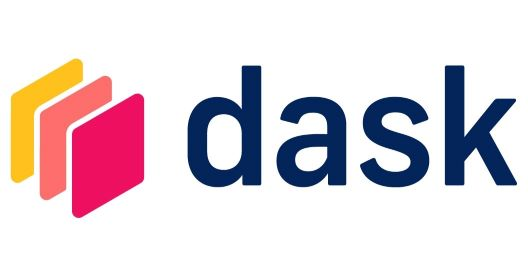


As we explore the use of Xarray for handling complex, multi-dimensional datasets in climate science, one challenge often arises: **the sheer volume of data can exceed your system's memory capacity.** To address this, we can leverage `Dask`, a flexible parallel computing library for analytic computing. Dask integrates smoothly with Xarray, providing out-of-the-box support for parallelizing operations and working with datasets that are larger than memory.<br>

The key advantage of `Dask` is the use of `'chunks'`: dataset is divided into smaller blocks along specified dimensions. Each chunk is processed independently, allowing for distributed computing.

#### Integrating Dask with Xarray
When used with Xarray, Dask allows you to create a distributed, chunked version of your datasets.


In [ ]:
# Open a dataset using Xarray and create Dask arrays
ds_fn = os.path.join(base_dir, 'data/himax_ghana_2016.nc')
ds = xr.open_dataset(ds_fn, chunks='auto')
# set the spatial_ref as coordinate
ds = ds.set_coords('spatial_ref')

In [ ]:
ds

In [ ]:
# Perform an operation that benefits from Dask
mean_temp = ds['himax'].mean(dim='time')

In [ ]:
mean_temp

In [ ]:
# Access a specific variable, say 'temperature'
himax = ds['himax']
himax